## Exploring the station table

In this notebook, we consider the number of observations available for each station as well as the range of dates for which observations are given.  

In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import pandas as pd

In [2]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Use inspect to list columns in each table
from sqlalchemy import inspect

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types for the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types for the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
from sqlalchemy import distinct

# Design a query to show how many stations are available in this dataset?

# First list the available stations in the measurement table.
query_results = session.query(Measurement.station).distinct().all()

for row in query_results:
    print(row)

# We can also just get the count of unique stations in the measurement table
session.query(func.count(distinct(Measurement.station))).scalar()

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# The most active station can be pulled in a query - we assign it the name most_active
most_active = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
most_active

'USC00519281'

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# What is the range of available dates for the most active station?
query_results = session.query(func.min(Measurement.date), func.max(Measurement.date)).\
    filter(Measurement.station == most_active).all()

for row in query_results:
    print(row)
    
# We can directly query for the last available date for the most active station 
# Or - we could pull it out of the query_results above: query_results[0][1]
last_active_date = session.query(func.max(Measurement.date)).\
    filter(Measurement.station == most_active).scalar()

# Now get one year back from the last_active_date -
last_active_date_dt = dt.datetime.strptime(last_active_date, '%Y-%m-%d')  # a datetime object
one_year_ago = last_active_date_dt - dt.timedelta(days=365)
one_year_ago = one_year_ago.strftime("%Y-%m-%d") # convert the datetime object back to a string

print(last_active_date, one_year_ago)

('2010-01-01', '2017-08-18')
2017-08-18 2016-08-18


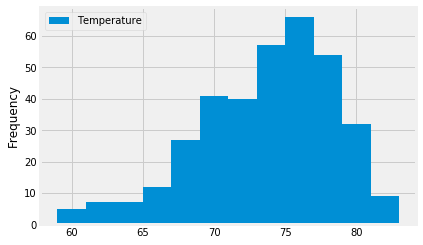

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_results = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == most_active).all()

#query_results[:10]
df_temp = pd.DataFrame(query_results, columns=['Temperature'])
df_temp.plot.hist(bins=12) # default is bins=10, bins=12 matches the sample graph

# What dates are available for the stations reporting?

We get differing numbers of stations in our queries, depending on the range of dates we filter on.  We also get different results depending on whether we pass in a datetime object for comparisons or a string date.

In [49]:
# A helper function
def one_year_ago(a_date, date_format="%Y-%m-%d", return_datetime=False):
    """
    Args: 
        a_date:  
            is a string representation of a date with the time-format specified in date_format 
            (default is %Y-%m-%d)
        date_format: 
            the format of a_date
        return_datetime:
            specifies whether the result should be returned as a string (the default) or a 
            datetime object.
            
    Returns: (Default) a string object that is the date one-year prior to a_date in the same format as
        a_date or a datetime object if return_datetime is True 
    """
    a_date = dt.datetime.strptime(a_date, date_format)
    one_year_prior = a_date - dt.timedelta(days=365)
    if return_datetime:
        return one_year_prior
    else:
        return one_year_prior.strftime(date_format)

# An example of the above function: 
start_date = "2018-01-01"
start_delta_dt = one_year_ago(start_date, return_datetime=True)
start_delta_str = one_year_ago(start_date)

print(f"Date: {start_date}")
print(f"Date one-year-prior (as a datetime object): {start_delta_dt}")
print(f"Date one-year-prior (as string): {start_delta_str}")


Date: 2018-01-01
Date one-year-prior (as a datetime object): 2017-01-01 00:00:00
Date one-year-prior (as string): 2017-01-01


In [31]:
# List all of the available stations in the station table
query_results = session.query(Station.station).all()
for row in query_results:
    print(row)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


In [32]:
# What are the results when we use a datetime object?
end_date = "2018-01-07"
end_delta_dt = one_year_ago(end_date, return_datetime=True)

sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_delta_dt).\
    filter(Measurement.date <= end_delta_dt).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for row in query_results:
    print(row)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.57)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.16999999999999998)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)


In [34]:
# What are the results when we use a string representation of the date?
end_delta_str = one_year_ago(end_date)

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_delta_str).\
    filter(Measurement.date <= end_delta_str).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for row in query_results:
    print(row)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)


## Consider the difference between the datetime and string date objects.
From the above, we see that using a datetime object or a string date will give different results.  We can see why by looking at what rows are pulled from the tables based on using the different representations of the dates.

In [41]:
# This only gives 6 stations and it depends on whether I pass in a datetime object or a string date.
# Using a datetime object excluded the start date.
sel = [Measurement.date,
       Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       Measurement.prcp]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_delta_dt).\
    filter(Measurement.date <= end_delta_dt).all()

for row in query_results:
    print(row)

('2017-01-02', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-03', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-04', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-05', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-06', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-07', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-02', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-03', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-04', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-05', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-06', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-07', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.801

In [42]:
# Using a string representation of the date:
# This also only gives 6 stations but it includes the start_date 

sel = [Measurement.date,
       Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       Measurement.prcp]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2017-01-01').\
    filter(Measurement.date <= '2017-01-07').all()

for row in query_results:
    print(row)

('2017-01-01', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-02', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-03', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-04', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-05', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-06', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-07', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-01', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29)
('2017-01-02', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-03', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-04', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-05', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.801

In [43]:
# You can get data on all 9 stations by not filtering on time.
sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for row in query_results:
    print(row)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1068.0899999999956)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 588.6399999999976)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 382.61999999999847)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 295.67999999999944)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 234.49000000000026)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 131.62000000000063)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 92.68000000000006)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 70.87000000000005)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 43.44000000000002)


In [45]:
# We can see that in 2017, two of the stations do not have any recordings
# and another station does not have any observations in the range 2017-01-01 to 2017-01-08
# hence we are only pulling date from six stations above.

dropped_obs = ['USC00517948', 'USC00518838', 'USC00511918']

sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       Measurement.prcp,
      Measurement.date]

query_results = session.query(*sel).\
    join(Measurement, Measurement.station == Station.station, isouter=True).\
    filter(Measurement.date >= '2017-01-01').\
    filter(Measurement.date <= '2017-01-07').\
    filter(Station.station.in_(dropped_obs)).all()

print(len(query_results)) # is 0 since no rows are available
for row in query_results: # prints nothing - no rows are in the query
    print(row)

0


In [46]:
# The following query gets at the heart of the problem.  We do not have observations after 2016 for two of the stations.
# query gives the earliest and lastest observation dates available for each of the stations.

sel = [Station.station,
       Station.name,
       func.min(Measurement.date),
       func.max(Measurement.date)]

query_results = session.query(*sel).\
    join(Measurement, Measurement.station == Station.station, isouter=True).\
    group_by(Station.station).all()

for row in query_results:
    print(row)

('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', '2010-01-01', '2015-10-30')
('USC00513117', 'KANEOHE 838.1, HI US', '2010-01-01', '2017-07-31')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', '2010-03-01', '2017-08-23')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', '2010-01-01', '2017-08-23')
('USC00517948', 'PEARL CITY, HI US', '2010-05-03', '2017-07-31')
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', '2010-01-01', '2015-11-20')
('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-01', '2017-08-18')
('USC00519397', 'WAIKIKI 717.2, HI US', '2010-01-01', '2017-08-23')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', '2010-01-01', '2017-08-23')


In [48]:
# A left outer join of station and measurement still can't get results for the missing date ranges:
# Using the ifnull function doesn't help since no rows are pulled for these stations after filtering.

sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.ifnull(func.sum(Measurement.prcp), 0)]

query_results = session.query(*sel).\
    join(Measurement, Station.station == Measurement.station, isouter=True).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2017-01-01').\
    filter(Measurement.date <= '2017-01-07').\
    group_by(Measurement.station).\
    order_by(func.ifnull(func.sum(Measurement.prcp), 0).desc()).all()

for row in query_results:
    print(row)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)


## Lessons:
* Using string representations for the dates in the queries gives the desired results.  SQLAlchemy can use both datetime and string dates but the string dates give the expected behavior when comparing dates.
* The output we receive depends on the range of dates given since not all stations are active on all dates.

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
